In [1]:
from dataset import *
from evaluator import *
from torch.utils.data import DataLoader

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable
import torch.autograd as autograd

from torchvision.utils import save_image, make_grid

import matplotlib.pyplot as plt

import tqdm

path = "./Conditional_DCGAN_WGANGP_"

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using {} device'.format(device))

Using cuda device


In [2]:
image_size = 64

trans = transforms.Compose([transforms.ToPILImage(),
                            transforms.Resize([image_size, image_size]),
                            transforms.CenterCrop([image_size, image_size]),
                            transforms.ToTensor(),
                            transforms.Normalize((0.5, 0.5, 0.5, 0.5), (0.5, 0.5, 0.5, 0.5)), # normalize to [-1, 1] for the last layer of generator is tanh()
                            ])

# preprocessing size -> 64x64
train = ICLEVRLoader("./", trans=trans, mode="train", preprocessing=None)
# test = ICLEVRLoader("./", mode="test")

batch_size = 128 # based on paper
train_loader = DataLoader(
    dataset=train, 
    batch_size=batch_size,
    num_workers = 4
)

data = json.load(open(os.path.join('./','test.json')))
obj = json.load(open(os.path.join('./','objects.json')))
test_labels = data
for i in range(len(test_labels)):
    for j in range(len(test_labels[i])):
        test_labels[i][j] = obj[test_labels[i][j]]
    tmp = np.zeros(len(obj))
    tmp[test_labels[i]] = 1
    test_labels[i] = tmp
test_labels = torch.tensor(test_labels).to(device)

> Found 18009 images...


In [3]:
class Generator(nn.Module):
    def __init__(self, n_classes, latent_dim, img_shape, n_channels):
        super(Generator, self).__init__()
        
        self.n_classes = n_classes
        self.label_emb = nn.Embedding(n_classes, n_classes)
        self.input_cnn = nn.Linear(n_classes+latent_dim, 128)

        self.main = nn.Sequential(
            # input is Z, going into a convolution
#             nn.ConvTranspose2d( img_shape, img_shape*8 , 4, 1, 0, bias=False), #input shape [batch_size, 64, 1, 1]
            nn.ConvTranspose2d( 128, img_shape*8 , 4, 1, 0, bias=False), # input shape [batch_size, 64, 2, 2]
            nn.BatchNorm2d(img_shape*8),
            nn.ReLU(True),
            # state size. (img_shape*8) x 4 x 4
            nn.ConvTranspose2d(img_shape * 8, img_shape * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 4),
            nn.ReLU(True),
            # state size. (img_shape*4) x 8 x 8
            nn.ConvTranspose2d( img_shape * 4, img_shape * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape * 2),
            nn.ReLU(True),
            # state size. (img_shape*2) x 16 x 16
            nn.ConvTranspose2d( img_shape * 2, img_shape, 4, 2, 1, bias=False),
            nn.BatchNorm2d(img_shape),
            nn.ReLU(True),
            # state size. (img_shape) x 32 x 32
            nn.ConvTranspose2d( img_shape, n_channels, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (n_channels) x 64 x 64
        )

    def forward(self, noise, labels):
        gen_input = torch.cat((labels, noise), -1).float()
        gen_input = self.input_cnn(gen_input).view(-1, 128, 1, 1)
        img = self.main(gen_input)
        return img


class Discriminator(nn.Module):
    def __init__(self, n_classes, img_shape):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.img_shape= img_shape
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.label_linear = nn.Linear(n_classes, img_shape*img_shape)        
        
        self.main = nn.Sequential(
            # input is (n_classes) x 64 x 64
            nn.Conv2d(4, img_shape, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape) x 32 x 32
            nn.Conv2d(img_shape, img_shape * 2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*2) x 16 x 16
            nn.Conv2d(img_shape * 2, img_shape * 4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*4) x 8 x 8
            nn.Conv2d(img_shape * 4, img_shape * 8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(img_shape * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (img_shape*8) x 4 x 4
            nn.Conv2d(img_shape * 8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
        )

    def forward(self, img, labels):
        # Concatenate label embedding and image to produce input
        labels = self.label_linear(labels.float()).view(-1, 1, self.img_shape, self.img_shape)
        d_in = torch.cat((img, labels), 1)
        validity = self.main(d_in).view(-1, 1)

        return validity

In [4]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# loss function
adversarial_loss = torch.nn.BCELoss()

# model 
n_classes = 24
latent_dim = 100
img_shape = 64
n_channels = 3
generator = Generator(n_classes, latent_dim, img_shape, n_channels).to(device)
discriminator = Discriminator(n_classes, img_shape).to(device)

generator.apply(weights_init)
discriminator.apply(weights_init)

# optimizer 
lr = 0.0002
b1 = 0.5
b2 = 0.999
# lr = 0.0001 # based on paper
# b1 = 0 # based on paper
# b2 = 0.9 # based on paper
optimizer_G = torch.optim.Adam(generator.parameters(), lr=lr, betas=(b1, b2))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(b1, b2))

In [5]:
def save_acc(filename, g_loss, d_loss, score):
    try:
        acc = np.load(filename)
        np_g_loss = acc['g_loss']
        np_d_loss = acc['d_loss']
        np_score = acc['score']
        np_g_loss = np.append(np_g_loss, g_loss)
        np_d_loss = np.append(np_d_loss, d_loss)
        np_score = np.append(np_score, score)
        np.savez(filename, g_loss=np_g_loss, d_loss=np_d_loss, score=np_score)
    except:
        g_loss = np.array(g_loss)
        d_loss = np.array(d_loss)
        score = np.array(score)
        np.savez(filename, g_loss=g_loss, d_loss=d_loss, score=score)
        
def test_eval(generator, epoch):
    np.random.seed(0)    
    generator.eval()
    eval_model = evaluation_model()
    batch_size = test_labels.shape[0]
    z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
    gen_imgs = generator(z, test_labels) # shape [batch_size, 3, 64, 64]
    if epoch % 10 == 0:
        show_image(gen_imgs)
    return eval_model.eval(gen_imgs, test_labels)

def show_image(gen_imgs):
    # step 1: convert it to [0 ,2]
    gen_imgs = gen_imgs +1
    
    # step 2: convert it to [0 ,1]
    gen_imgs = gen_imgs - gen_imgs.min()
    gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())
    
    grid = make_grid(gen_imgs)
    plt.figure(figsize=(14, 14))
    plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
    plt.show()

In [6]:
FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

def compute_gradient_penalty(D, real_samples, fake_samples, real_labels, gen_labels):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = FloatTensor(np.random.random((real_samples.size(0), 1, 1, 1))).to(device)
    label_alpha = FloatTensor(np.random.random((real_samples.size(0), 1))).to(device)
    # Get random interpolation between real and fake samples
    interpolates = (alpha * real_samples + ((1 - alpha) * fake_samples)).requires_grad_(True)
    label_interpolates = (label_alpha * real_labels + ((1 - label_alpha) * gen_labels)).requires_grad_(True)
    d_interpolates = D(interpolates, label_interpolates)
    fake = Variable(FloatTensor(real_samples.shape[0], 1).fill_(1.0), requires_grad=False).to(device)
    # Get gradient w.r.t. interpolates
    gradients = autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    gradients = gradients.view(gradients.size(0), -1)
    gradient_penalty = ((gradients.norm(2, dim=1) - 1) ** 2).mean()
    return gradient_penalty

[Epoch 1/100] [D loss: -9.519568] [G loss: 39.728236] [test score: 0.083333]
[Epoch 2/100] [D loss: -5.730105] [G loss: 14.086742] [test score: 0.083333]
[Epoch 3/100] [D loss: -5.431524] [G loss: 5.584170] [test score: 0.138889]
[Epoch 4/100] [D loss: -5.168340] [G loss: 6.629340] [test score: 0.111111]
[Epoch 5/100] [D loss: -4.883655] [G loss: 4.634974] [test score: 0.083333]
[Epoch 6/100] [D loss: -4.618956] [G loss: 7.018585] [test score: 0.138889]
[Epoch 7/100] [D loss: -4.590063] [G loss: 7.079433] [test score: 0.097222]
[Epoch 8/100] [D loss: -4.790218] [G loss: 15.763124] [test score: 0.097222]
[Epoch 9/100] [D loss: -4.842283] [G loss: 22.433198] [test score: 0.138889]


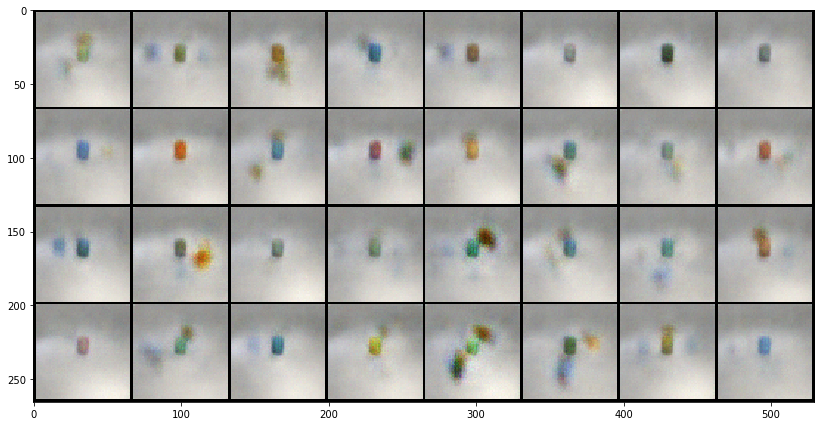

[Epoch 10/100] [D loss: -4.772623] [G loss: 25.233722] [test score: 0.097222]
[Epoch 11/100] [D loss: -4.567156] [G loss: 27.685180] [test score: 0.111111]
[Epoch 12/100] [D loss: -4.365876] [G loss: 24.060294] [test score: 0.152778]
[Epoch 13/100] [D loss: -4.213680] [G loss: 24.759633] [test score: 0.208333]
[Epoch 14/100] [D loss: -4.107168] [G loss: 33.032874] [test score: 0.180556]
[Epoch 15/100] [D loss: -3.976680] [G loss: 45.205755] [test score: 0.180556]
[Epoch 16/100] [D loss: -3.784429] [G loss: 46.090195] [test score: 0.208333]
[Epoch 17/100] [D loss: -3.680718] [G loss: 45.317346] [test score: 0.277778]
[Epoch 18/100] [D loss: -3.573165] [G loss: 37.674422] [test score: 0.194444]
[Epoch 19/100] [D loss: -3.358558] [G loss: 42.420447] [test score: 0.166667]


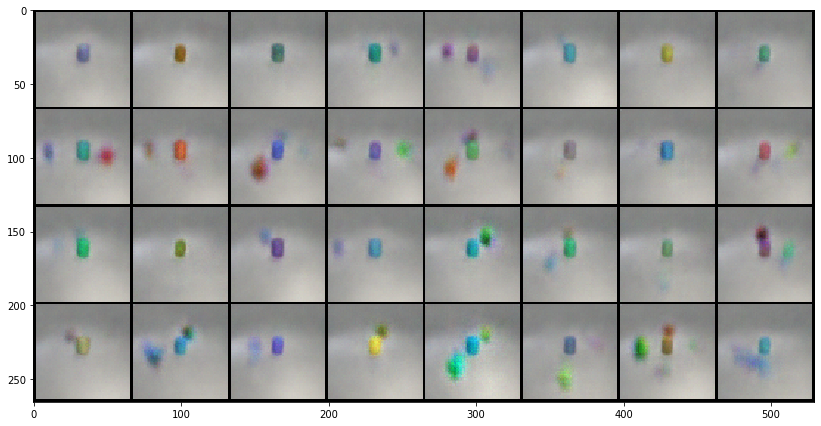

[Epoch 20/100] [D loss: -3.211459] [G loss: 44.721407] [test score: 0.180556]
[Epoch 21/100] [D loss: -3.204059] [G loss: 55.740976] [test score: 0.208333]
[Epoch 22/100] [D loss: -3.136576] [G loss: 48.119919] [test score: 0.180556]
[Epoch 23/100] [D loss: -3.120245] [G loss: 51.778733] [test score: 0.138889]
[Epoch 24/100] [D loss: -3.131996] [G loss: 55.456007] [test score: 0.194444]
[Epoch 25/100] [D loss: -3.156787] [G loss: 59.634696] [test score: 0.236111]
[Epoch 26/100] [D loss: -3.141545] [G loss: 59.052880] [test score: 0.250000]
[Epoch 27/100] [D loss: -3.161239] [G loss: 55.951922] [test score: 0.277778]
[Epoch 28/100] [D loss: -3.134084] [G loss: 56.299143] [test score: 0.277778]
[Epoch 29/100] [D loss: -3.057168] [G loss: 56.550501] [test score: 0.250000]


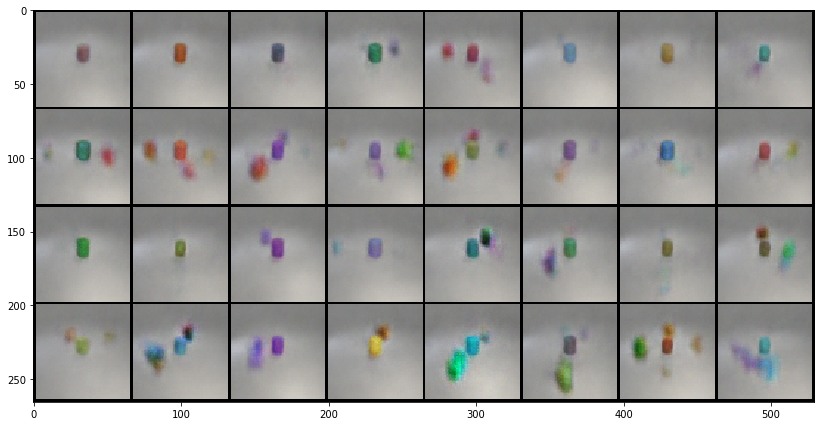

[Epoch 30/100] [D loss: -3.030085] [G loss: 56.447730] [test score: 0.291667]
[Epoch 31/100] [D loss: -3.027507] [G loss: 55.497811] [test score: 0.250000]
[Epoch 32/100] [D loss: -3.040682] [G loss: 56.259799] [test score: 0.222222]
[Epoch 33/100] [D loss: -3.033814] [G loss: 54.287864] [test score: 0.222222]
[Epoch 34/100] [D loss: -3.059120] [G loss: 54.269584] [test score: 0.250000]
[Epoch 35/100] [D loss: -3.105737] [G loss: 54.701996] [test score: 0.236111]
[Epoch 36/100] [D loss: -3.080218] [G loss: 47.630086] [test score: 0.319444]
[Epoch 37/100] [D loss: -3.138174] [G loss: 45.273411] [test score: 0.236111]
[Epoch 38/100] [D loss: -3.201410] [G loss: 43.211201] [test score: 0.277778]
[Epoch 39/100] [D loss: -3.140538] [G loss: 43.644153] [test score: 0.222222]


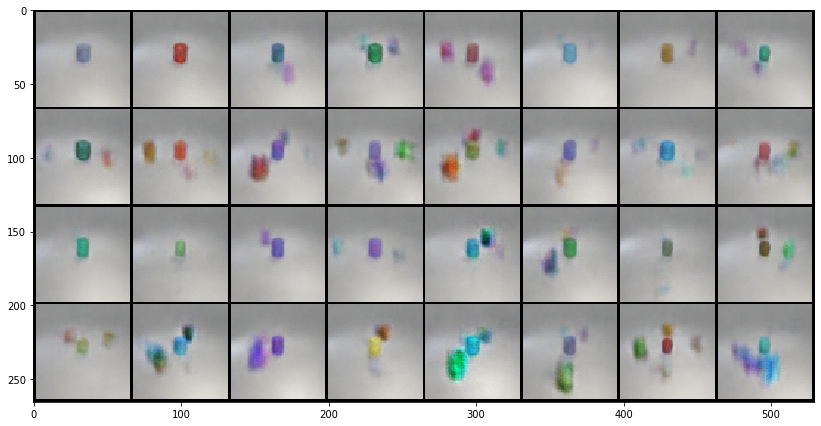

[Epoch 40/100] [D loss: -3.004610] [G loss: 41.631193] [test score: 0.263889]
[Epoch 41/100] [D loss: -2.962576] [G loss: 42.100055] [test score: 0.263889]
[Epoch 42/100] [D loss: -2.954964] [G loss: 43.620757] [test score: 0.277778]
[Epoch 43/100] [D loss: -2.969610] [G loss: 43.623897] [test score: 0.305556]
[Epoch 44/100] [D loss: -2.994653] [G loss: 43.908404] [test score: 0.319444]
[Epoch 45/100] [D loss: -3.015582] [G loss: 44.082400] [test score: 0.277778]
[Epoch 46/100] [D loss: -3.040262] [G loss: 45.832036] [test score: 0.291667]
[Epoch 47/100] [D loss: -3.041078] [G loss: 44.976444] [test score: 0.250000]
[Epoch 48/100] [D loss: -3.015758] [G loss: 41.290863] [test score: 0.291667]
[Epoch 49/100] [D loss: -2.961676] [G loss: 38.191606] [test score: 0.263889]


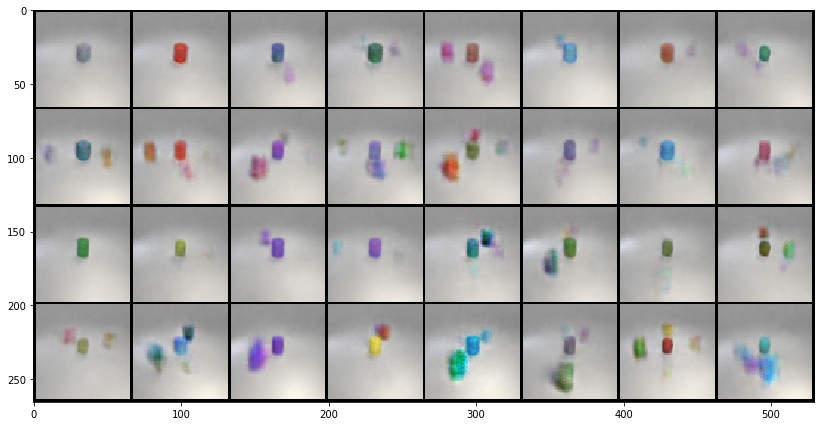

[Epoch 50/100] [D loss: -2.934139] [G loss: 36.560617] [test score: 0.263889]
[Epoch 51/100] [D loss: -2.924285] [G loss: 36.470581] [test score: 0.277778]
[Epoch 52/100] [D loss: -2.931163] [G loss: 36.144366] [test score: 0.263889]
[Epoch 53/100] [D loss: -2.947074] [G loss: 34.571905] [test score: 0.194444]
[Epoch 54/100] [D loss: -2.959233] [G loss: 32.958071] [test score: 0.250000]
[Epoch 55/100] [D loss: -2.946272] [G loss: 30.925830] [test score: 0.250000]
[Epoch 56/100] [D loss: -2.956714] [G loss: 30.496958] [test score: 0.263889]
[Epoch 57/100] [D loss: -2.969663] [G loss: 30.158501] [test score: 0.361111]
[Epoch 58/100] [D loss: -2.962408] [G loss: 29.066916] [test score: 0.347222]
[Epoch 59/100] [D loss: -2.971481] [G loss: 29.126979] [test score: 0.277778]


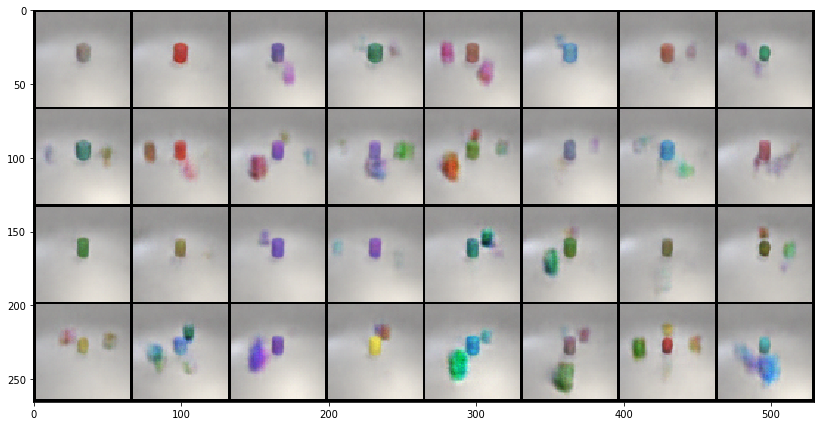

[Epoch 60/100] [D loss: -2.957946] [G loss: 30.593045] [test score: 0.277778]
[Epoch 61/100] [D loss: -2.954936] [G loss: 30.274259] [test score: 0.263889]
[Epoch 62/100] [D loss: -2.946841] [G loss: 29.958650] [test score: 0.250000]
[Epoch 63/100] [D loss: -2.936214] [G loss: 27.255363] [test score: 0.277778]
[Epoch 64/100] [D loss: -2.911369] [G loss: 24.338827] [test score: 0.277778]
[Epoch 65/100] [D loss: -2.903296] [G loss: 22.878805] [test score: 0.263889]
[Epoch 66/100] [D loss: -2.898438] [G loss: 21.849635] [test score: 0.250000]
[Epoch 67/100] [D loss: -2.911688] [G loss: 20.050465] [test score: 0.250000]
[Epoch 68/100] [D loss: -2.911420] [G loss: 18.879363] [test score: 0.208333]
[Epoch 69/100] [D loss: -2.907650] [G loss: 17.274682] [test score: 0.277778]


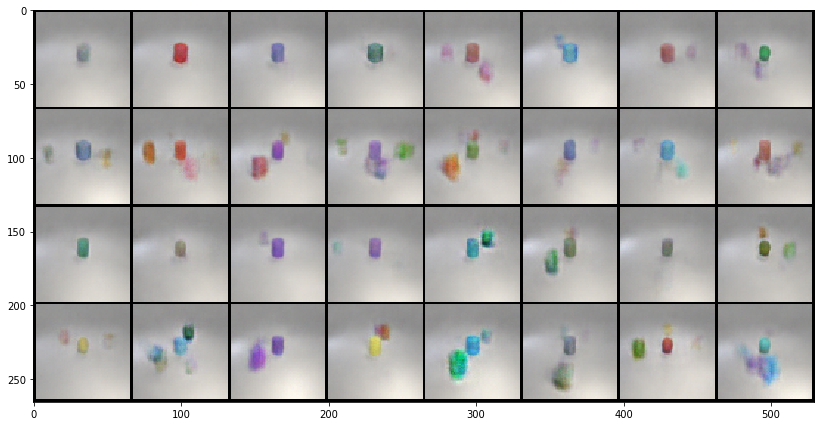

[Epoch 70/100] [D loss: -2.916351] [G loss: 15.133850] [test score: 0.250000]
[Epoch 71/100] [D loss: -2.939480] [G loss: 15.517269] [test score: 0.319444]
[Epoch 72/100] [D loss: -2.929454] [G loss: 16.166968] [test score: 0.319444]
[Epoch 73/100] [D loss: -2.906857] [G loss: 16.263262] [test score: 0.347222]
[Epoch 74/100] [D loss: -2.880333] [G loss: 15.093852] [test score: 0.319444]
[Epoch 75/100] [D loss: -2.860160] [G loss: 12.983934] [test score: 0.291667]
[Epoch 76/100] [D loss: -2.855712] [G loss: 9.422138] [test score: 0.236111]
[Epoch 77/100] [D loss: -2.844767] [G loss: 8.444084] [test score: 0.250000]
[Epoch 78/100] [D loss: -2.838477] [G loss: 8.412011] [test score: 0.250000]
[Epoch 79/100] [D loss: -2.835944] [G loss: 9.053942] [test score: 0.305556]


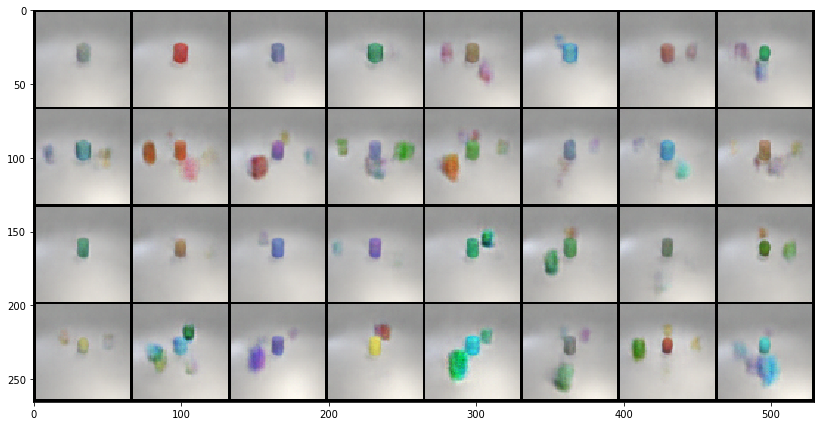

[Epoch 80/100] [D loss: -2.838857] [G loss: 10.022842] [test score: 0.375000]
[Epoch 81/100] [D loss: -2.828861] [G loss: 10.419722] [test score: 0.319444]
[Epoch 82/100] [D loss: -2.820686] [G loss: 10.789338] [test score: 0.319444]
[Epoch 83/100] [D loss: -2.817609] [G loss: 10.129121] [test score: 0.347222]
[Epoch 84/100] [D loss: -2.837589] [G loss: 9.503716] [test score: 0.263889]
[Epoch 85/100] [D loss: -2.845470] [G loss: 8.437283] [test score: 0.263889]
[Epoch 86/100] [D loss: -2.842640] [G loss: 6.994210] [test score: 0.263889]
[Epoch 87/100] [D loss: -2.836265] [G loss: 6.128824] [test score: 0.277778]
[Epoch 88/100] [D loss: -2.839534] [G loss: 4.523324] [test score: 0.305556]
[Epoch 89/100] [D loss: -2.871177] [G loss: 4.630974] [test score: 0.319444]


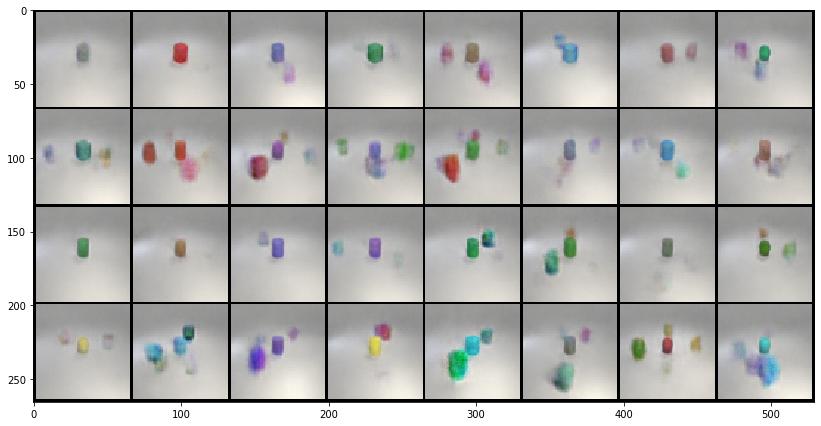

[Epoch 90/100] [D loss: -2.870131] [G loss: 5.643448] [test score: 0.305556]
[Epoch 91/100] [D loss: -2.851630] [G loss: 6.459058] [test score: 0.263889]
[Epoch 92/100] [D loss: -2.841438] [G loss: 6.330202] [test score: 0.277778]
[Epoch 93/100] [D loss: -2.827914] [G loss: 5.355838] [test score: 0.263889]
[Epoch 94/100] [D loss: -2.845308] [G loss: 5.188081] [test score: 0.291667]
[Epoch 95/100] [D loss: -2.826736] [G loss: 4.709819] [test score: 0.305556]
[Epoch 96/100] [D loss: -2.820371] [G loss: 5.448996] [test score: 0.305556]
[Epoch 97/100] [D loss: -2.818405] [G loss: 5.828705] [test score: 0.277778]
[Epoch 98/100] [D loss: -2.825043] [G loss: 5.704488] [test score: 0.319444]
[Epoch 99/100] [D loss: -2.827121] [G loss: 4.773768] [test score: 0.305556]


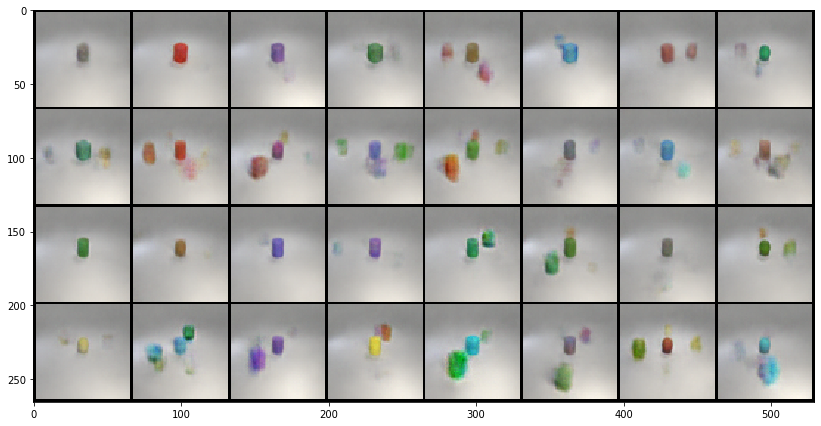

[Epoch 100/100] [D loss: -2.830132] [G loss: 4.170339] [test score: 0.319444]



In [7]:
# training 
epochs = 100
n_critic = 5 # number of training steps for discriminator per iter
lambda_gp = 10 # Loss weight for gradient penalty\
save = True
g_loss_list = []
d_loss_list = []
max_g_loss = np.inf
max_d_loss = -np.inf

FloatTensor = torch.FloatTensor
LongTensor = torch.LongTensor

for epoch in tqdm.notebook.tqdm(range(epochs)):
    total_d_loss = 0
    total_g_loss = 0
    
    for i, (real_imgs, labels) in enumerate(train_loader):
        batch_size = real_imgs.shape[0]

        real_imgs = real_imgs[:, :3].to(device)
        real_labels = labels.to(device)

        # Sample noise and labels as generator input
        z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
#         gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, (batch_size, 1)))) # shape [batch_size, 1] with 0~24
#         one_hot =  np.zeros((batch_size, n_classes))
#         one_hot[np.arange(batch_size), gen_labels] = 1
#         gen_labels = torch.from_numpy(one_hot).to(device)        
        
        # Generate a batch of images
        gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
        
        # ---------------------
        #  Train Discriminator
        # ---------------------

        optimizer_D.zero_grad()

         # Real images
        real_validity = discriminator(real_imgs, real_labels)
        # Fake images
        fake_validity = discriminator(gen_imgs, real_labels)
        # Gradient penalty
        gradient_penalty = compute_gradient_penalty(discriminator, real_imgs.data, gen_imgs.data, real_labels.data, real_labels.data)
        # Adversarial loss
        d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gradient_penalty

        d_loss.backward()
        optimizer_D.step()

        # -----------------
        #  Train Generator
        # -----------------
        # Train the generator every n_critic steps
        if i % n_critic == 0:
            optimizer_G.zero_grad()

            # Loss measures generator's ability to fool the discriminator
            gen_imgs = generator(z, real_labels) # shape [batch_size, 3, 64, 64]
            
            fake_validity = discriminator(gen_imgs, real_labels)
            g_loss = -torch.mean(fake_validity)

            g_loss.backward()
            optimizer_G.step()
        
        total_d_loss += d_loss.item()
        total_g_loss += g_loss.item()
        
        
    score = test_eval(generator, epoch+1)
    total_d_loss /= len(train_loader)
    total_g_loss /= (len(train_loader)/n_critic)

    print(
        "[Epoch %d/%d] [D loss: %f] [G loss: %f] [test score: %f]"
        % (epoch+1, epochs, total_d_loss, total_g_loss, score)
    )

    # loss save
    if save:
        save_acc(path+"loss.npz", total_g_loss, total_d_loss, score)
    else:
        g_loss_list.append(total_g_loss)
        d_loss_list.append(total_d_loss)
    
    if save:
        if max_g_loss > total_g_loss:
            max_g_loss = total_g_loss
            torch.save(generator, path+"generator.pt")
        if max_d_loss < total_d_loss:
            max_d_loss = total_d_loss
            torch.save(discriminator, path+"discriminator.pt")

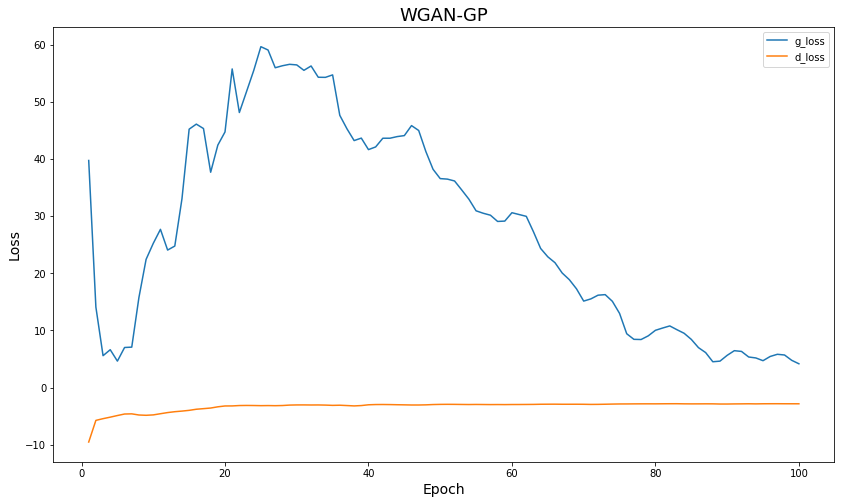

In [15]:
plt.figure(figsize=(14, 8))

load = True
if load:
    acc = np.load(path+"loss.npz")
    g_loss = acc['g_loss']
    d_loss = acc['d_loss']
    score = acc["score"]

plt.title("WGAN-GP", fontsize=18)
plt.ylabel("Loss", fontsize=14)
# plt.ylabel("Score", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
x = np.arange(1, len(g_loss)+1)
plt.plot(x, g_loss, label="g_loss")
plt.plot(x, d_loss, label="d_loss")
# plt.plot(x, score, label="test_score")
plt.legend()
plt.show()

In [9]:
## evaluate
generator = torch.load('./Conditional_DCGAN_WGANGP_generator.pt', map_location=device)
# generator = torch.load('./generator.pt', map_location=device)
generator.eval()

batch_size = 32
z = Variable(FloatTensor(np.random.normal(0, 1, (batch_size, latent_dim)))).to(device) # shape [batch_size, latent_dim] with normal distribution
# gen_labels = Variable(LongTensor(np.random.randint(0, n_classes, (batch_size, 1)))) # shape [batch_size, 1] with 0~24
# gen_labels = Variable(LongTensor(np.linspace(0, 23, 24)))
# one_hot =  np.zeros((batch_size, n_classes))
# one_hot[np.arange(batch_size), gen_labels] = 1
# gen_labels = torch.from_numpy(one_hot).to(device)  

# gen_labels = torch.tensor(0)
# for label in test_loader:
#     gen_labels = label.to(device)
# print(gen_labels)

data = json.load(open(os.path.join('./','test.json')))
obj = json.load(open(os.path.join('./','objects.json')))
gen_labels = data
for i in range(len(gen_labels)):
    for j in range(len(gen_labels[i])):
        gen_labels[i][j] = obj[gen_labels[i][j]]
    tmp = np.zeros(len(obj))
    tmp[gen_labels[i]] = 1
    gen_labels[i] = tmp
gen_labels = torch.tensor(gen_labels).to(device)
# print(gen_labels)

gen_imgs = generator(z, gen_labels) # shape [batch_size, 3, 64, 64]

0.08333333333333333


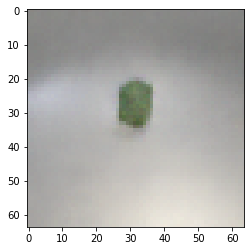

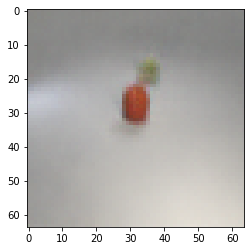

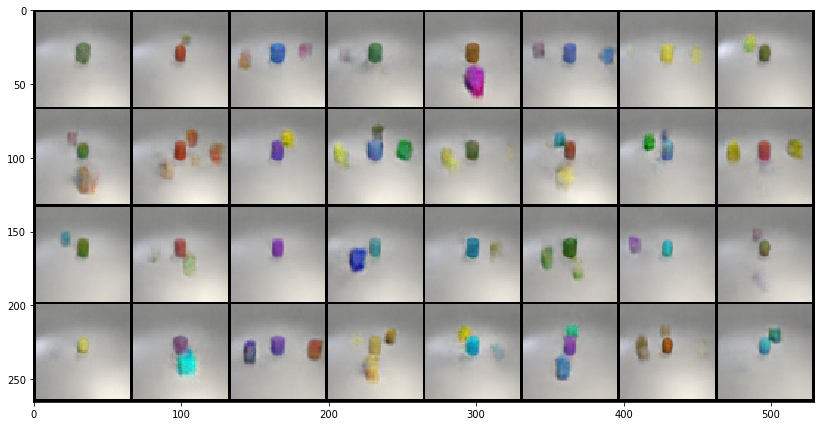

In [10]:
 # step 1: convert it to [0 ,2]
gen_imgs = gen_imgs +1

 # step 2: convert it to [0 ,1]
gen_imgs = gen_imgs - gen_imgs.min()
gen_imgs = gen_imgs / (gen_imgs.max() - gen_imgs.min())

eval_model = evaluation_model()
print(eval_model.eval(gen_imgs, gen_labels))


plt.imshow(np.transpose(gen_imgs[0].detach().cpu().numpy(), (1, 2, 0)))
plt.show()
plt.imshow(np.transpose(gen_imgs[1].detach().cpu().numpy(), (1, 2, 0)))
plt.show()

grid = make_grid(gen_imgs)
plt.figure(figsize=(14, 14))
plt.imshow(np.transpose(grid.detach().cpu().numpy(), (1, 2, 0)))
plt.show()

In [11]:
eval_model = evaluation_model()
for images, labels in train_loader:
    images = images.to(device)
    labels = labels.to(device)
    out = F.interpolate(images, size=64)  #The resize operation on tensor.
    print(out.shape)
    print(eval_model.eval(images[:, :3], labels))
#     grid = make_grid(out)
    break

torch.Size([128, 4, 64, 64])
0.9647058823529412


torch.Size([4, 64, 64])


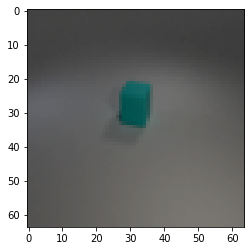

In [12]:
img, label = train.__getitem__(0)
 # step 1: convert it to [0 ,2]
img = img +1

 # step 2: convert it to [0 ,1]
img = img - img.min()
img = img / (img.max() - img.min())

print(img.shape)
plt.imshow(np.transpose(img,(1,2,0)))